# Load Data

In [771]:
# Imports
# from settings import *
# import analyze_cascade
import datetime
import pandas as pd
import numpy as np
from itertools import groupby
from collections import Counter
from random import shuffle, choices, randint
import math

from keras.utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import LSTM, Input, Dense, Dropout
from keras.layers import concatenate as kerasconc

import matplotlib.pyplot as plt
from matplotlib import rcParams
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp

In [772]:
metadata_file = 'metadata_anon.txt'

In [773]:
# Read meta data 
fin = open(metadata_file,'r')
lines = fin.readlines()
fin.close()
cascade_id2metadata={}
for line in lines:
    line = line.replace('\n','')
    item = eval(line)
    cascade_id2metadata[item[0]] = item[1]

## Data and Descriptives

### Static Measures

#### Get data

In [774]:
cid = []
veracity = []
virality = []
depth = []
breadth = []
size = []
verified = []
nfollowers = []
nfollowees = []
engagement = []
category = []
for cascade,metadata in cascade_id2metadata.items():
    if metadata['virality'] is not None: # Exclude every cascade of length 0 (--> no retweets)
        cid.append(cascade)
        veracity.append(metadata['veracity'])
        virality.append(metadata['virality'])
        depth.append(metadata['depth'])
        breadth.append(metadata['max_breadth'])
        size.append(metadata['size'])
        verified.append(metadata['verified_list'][0])
        nfollowers.append(metadata['num_followers_list'][0])
        nfollowees.append(metadata['num_followees_list'][0])
        engagement.append(metadata['engagement_list'][0])
        category.append(metadata['rumor_category'])

# Convert to data frame
static = pd.DataFrame({'cid': cid,
                       'veracity': veracity,
                       'virality': virality,
                       'depth': depth,
                       'breadth': breadth,
                       'size': size,
                       'verified': verified,
                       'nfollowers': nfollowers,
                       'nfollowees': nfollowees,
                       'engangement': engagement,
                       'category': category})

#### Descriptives

#### Preprocessing

In [775]:
# Make x variables categorical with integer values
def x_in_df_to_int(df, x):
    df[x].fillna('Unknown')
    df[x] = df[x].astype('category')
    num = list(range(len(df[x].cat.categories)))
    df[x] = df[x].cat.rename_categories(num)
    df[x] = df[x].astype('int')
    return df

static = x_in_df_to_int(static, 'verified')
static = x_in_df_to_int(static, 'category')

In [776]:
# Drop NAs: Recall a few buckets were too small for LSTM --> obs removed --> resulting in NAs with merge --> drop
static = static.dropna(axis=0, how='any')

In [777]:
# Change format of y
def veracity_to_categorical(v):
    if v == 'FALSE':
        vbin = [1,0,0]
    elif v == 'MIXED':
        vbin = [0,1,0]
    elif v == 'TRUE':
        vbin = [0,0,1]
    elif v is None:
        vbin = None
    return vbin

# Convert y to classification
def reverse_veracity_to_categorical(vbin):
    if vbin[0] == 1:
        v = 'FALSE'
    elif vbin[1] == 1:
        v = 'MIXED'
    elif vbin[2] == 1:
        v = 'TRUE'
    return v

def var_to_binary_in_df(df, var, fct):
    lst = []
    for i in df[var]:
        lst.extend([fct(i)])
    var_new = pd.Series(data=lst, dtype='object')
    df[var] = np.asarray(list(range(len(lst))))
    df[var] = pd.Series(lst, dtype='object')
    return df

# functions are run after combining the models because on static NAs are randomly/strangely introduces

### Dynamic measures

#### Descriptives about sequence lengths

In [778]:
len_user = [] # user list: length of sequence is the same as num_followees_list, engagement list, etc
len_infodiff = [] # info diffusion list: length of sequence is the same for depth2breadth, depth2time and depth2uu
len_user_full = []
len_infodiff_full = []
for cascade,metadata in cascade_id2metadata.items():
    if metadata['virality'] is not None: # Exclude every cascade of length 0 (--> no retweets)
        len_user.append(len(metadata['uu2time'].keys()))
        len_infodiff.append(len(metadata['depth2breadth'].keys()))
    len_user_full.append(len(metadata['uu2time'].keys()))
    len_infodiff_full.append(len(metadata['depth2breadth'].keys()))
    
# Convert to data frame
dynamic_len = pd.DataFrame(
    {'user ': len_user, 
     'information_diffusion': len_infodiff})
dynamic_len_full =  pd.DataFrame(
    {'user ': len_user_full, 
     'information_diffusion': len_infodiff_full})    

In [779]:
# Get summary full
dynamic_len_full.describe(percentiles = [0.25, 0.5, 0.75, 1])

,information_diffusion,user
count,126301.000000,126301.000000
mean,0.568974,31.945392
std,1.108173,550.496787
min,0.000000,1.000000
25%,0.000000,1.000000
50%,0.000000,1.000000
75%,1.000000,2.000000
100%,24.000000,46895.000000
max,24.000000,46895.000000


In [780]:
# Get summary when excluding cascades of length 0
dynamic_len.describe(percentiles = [0.25, 0.5, 0.75, 1])

,information_diffusion,user
count,42081.000000,42081.000000
mean,1.707707,93.878829
std,1.319555,950.694376
min,1.000000,2.000000
25%,1.000000,2.000000
50%,1.000000,4.000000
75%,2.000000,9.000000
100%,24.000000,46895.000000
max,24.000000,46895.000000


## LSTM Depth

### Get data

In [781]:
# Function to get expression of each item in a dictionary entry
def get_expression_list(entry):
    expression = []
    for i in entry.keys():
        expression.append(float(entry[i]))
    return expression

# Get data in list format
depth = []
for cascade,metadata in cascade_id2metadata.items():
    if metadata['virality'] is not None:       
        # Get depth
        veracity = veracity_to_categorical(metadata['veracity'])
        depth2time = get_expression_list(metadata['depth2time'])
        depth2uu = get_expression_list(metadata['depth2uu'])
        depth2breadth = get_expression_list(metadata['depth2breadth']) 
        depth_id = []
        for time, uu, breadth in zip(depth2time, depth2uu, depth2breadth):
            depth_t = [cascade, 
                      veracity,
                      time, uu, breadth]
            depth_id.append(depth_t)
        depth.extend([depth_id])

### Bucketing and Padding

In [782]:
# Function: Create training and test set
def split_list(lst, train_size): # train_size is a proportion
    split = len(lst) * train_size
    if split.is_integer():
        split = int(split)
        return lst[:split], lst[split:]
    else:
        split = math.floor(split) + 1
        return lst[:split], lst[split:]
    
# Function: Padding for groups of equal batches
def padding(lst, bsize):
    if len(lst) % bsize != 0:
        psize = bsize - (len(lst) % 5)
        samples = choices(lst, k=psize)
        lst.extend(samples)
    return lst

# Get sublist
def get_sublist(list_in_list, start, stop):
    x = []
    for lst in list_in_list:
        x_id = []
        for sublist in lst:
            if stop is None:
                x_id.append(sublist[start:])
            elif start is None:
                x_id.append(sublist[:stop])
            else:
                x_id.append(sublist[start:stop])
        x.extend([x_id])
    return x

# Separate id, x and y
def separate(list_in_list):
    cid = []
    y = []
    for lst in list_in_list:
        cid.append(lst[0][0]) # only one id is needed
        # The following code would assume target replication in the model
#         veracity_id = []
#         for sublist in lst:
#             veracity_id.extend([sublist[1]])
#         veracity.append(veracity_id)
        y.append(lst[0][1])
    x = get_sublist(list_in_list,2,None)
    return cid, y, x

# Function to get outcome distribution
def get_outcome_distr(lst):
    y = []
    for l in lst:
        y.append(reverse_veracity_to_categorical(l[0][1]))
    Falses = Counter(y)['FALSE']
    Mixeds = Counter(y)['MIXED']
    Trues = Counter(y)['TRUE']
    return np.array([Falses, Mixeds, Trues])

# Function to check if outcome distribution is not too extremely unbalanced
def check_outcome_distr(array, min_share_small_group):
    max_array = max(array)
    if sum(array) == max_array:
        return False
    else:
        sum_rest = sum(array) - max_array
        if sum_rest >= max_array:
            return True
        else:
            share = sum_rest / max_array
            if share >= min_share_small_group:
                return True
            else:
                return False

In [867]:
# Set globally batch_size and group_size for LSTMs
batch_size = 25
min_train_group_size = 100

# Group by sequence length and append to have batches with a multiple of 10
depth.sort(key=len, reverse=True)   # Sort data in reverse order 
x_train = []
x_test = []
y_train = []
y_test = []
cid_train = []
cid_test = []
pruning = False
for k, g in groupby(depth, len):
    group = list(g)
    # Check if a moved group is to be added
    if pruning:
        # Prune last timesteps
        moved_group_pruned = []
        for x in moved_group:
            moved_group_pruned.append(x[:len(group[0])])
        group.extend(moved_group_pruned)
        pruning = False
    # Check outcome distribution (prevent too small groups or groups with single outcomes in the training set)
    outcomes = get_outcome_distr(group)
    if len(group) * 0.5 >= min_train_group_size and check_outcome_distr(outcomes, 0.2):
        shuffle(group)
        # Create train and test set
        train_group, test_group = split_list(group, 0.5)
        # Check that train set has no single outcomes
        outcomes_train = get_outcome_distr(train_group)
        while not check_outcome_distr(outcomes_train, 0.2):
            shuffle(group)
            train_group, test_group = split_list(group, 0.5)
            outcomes_train = get_outcome_distr(train_group)
        # Padd for equal batch size
        train_group_padded = padding(train_group, batch_size)
        test_group_padded = padding(test_group, batch_size)
        # Separate list
        cid_train_group, y_train_group, x_train_group = separate(train_group)
        cid_test_group, y_test_group, x_test_group = separate(test_group)
        # Append:  convert y and x into numpy arrays for nn models
        x_train.append(np.array(x_train_group))
        x_test.append(np.array(x_test_group))
        y_train.append(np.array(y_train_group))
        y_test.append(np.array(y_test_group))
        cid_train.append(cid_train_group)
        cid_test.append(cid_test_group)
    else:
        pruning = True
        moved_group = group

### Group descriptives

In [868]:
def group_descriptives(x_set, y_set):
    # Group size, sequence length and outcome distribution
    i = 1
    ver_total = []
    for x,y in zip(x_set, y_set):
        ver = []
        for j in y:
            ver.append(reverse_veracity_to_categorical(j))
        print('Group: ', i, ' ', 
              'Size: ', len(x),
              ' Seq. length:', len(x[randint(0,len(x)-1)]),
              ' Y distr.:', Counter(ver))
        ver_total.extend(ver)
        i += 1
    print('\n\nY distr. overall (Test):', Counter(ver_total))
    
group_descriptives(x_train, y_train)

Group:  1   Size:  455  Seq. length: 6  Y distr.: Counter({'FALSE': 369, 'TRUE': 45, 'MIXED': 41})
Group:  2   Size:  345  Seq. length: 5  Y distr.: Counter({'FALSE': 258, 'TRUE': 51, 'MIXED': 36})
Group:  3   Size:  780  Seq. length: 4  Y distr.: Counter({'FALSE': 592, 'TRUE': 113, 'MIXED': 75})
Group:  4   Size:  1810  Seq. length: 3  Y distr.: Counter({'FALSE': 1403, 'TRUE': 240, 'MIXED': 167})
Group:  5   Size:  4810  Seq. length: 2  Y distr.: Counter({'FALSE': 3695, 'TRUE': 665, 'MIXED': 450})
Group:  6   Size:  12980  Seq. length: 1  Y distr.: Counter({'FALSE': 9704, 'TRUE': 1943, 'MIXED': 1333})


Y distr. overall (Test): Counter({'FALSE': 16021, 'TRUE': 3057, 'MIXED': 2102})


### Preprocessing

In [869]:
# Function to standardize the list
def standardization_lst(lst, index, mean, std):
    for array3d in lst:
        for array2d in array3d:
            for vector in array2d:
                vector[index] = (vector[index] - mean) / std
    return lst

# Function to compute mean and std of variable and then standardizes this variable in list
def standardize_lst_var(a_list, b_list, index):
    var = []
    # Compute mean and std from train data (list a)
    for array3d in a_list:
        for array2d in array3d:
            for vector in array2d:
                var.append(vector[index])
    var = np.array(var)
    var_mean = np.mean(var)
    var_std = np.std(var)
    # Standardize list a and b with data mean and var from a
    a_list_std = standardization_lst(a_list, index, var_mean, var_std)
    b_list_std = standardization_lst(b_list, index, var_mean, var_std)
    return a_list_std, b_list_std

# Standardize all variables
def standardize_lst_all(a_list, b_list):
    length = len(a_list[0][0][0])
    indices = list(range(length))
    for i in indices:
        std_a, std_b = standardize_lst_var(a_list, b_list, i)
    return std_a, std_b

x_train, x_test = standardize_lst_all(x_train, x_test)

### Model

In [880]:
# Create LSTM model
model = Sequential()
model.add(LSTM(5, input_shape = (None, 3),  return_sequences = False))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [881]:
# Fit model and get train predictions
train_pred = []
test_pred = []
for X,Y,Z in zip(x_train, y_train, x_test):
    hist = model.fit(X, Y, epochs=3, batch_size=batch_size)
    pred1 = model.predict(X, batch_size=batch_size)
    pred2 = model.predict(Z, batch_size=batch_size)
    train_pred.append(pred1)
    test_pred.append(pred2)

Epoch 1/3
455/455 [==============================] - 4s 8ms/step - loss: 0.9867 - acc: 0.7604
Epoch 2/3
455/455 [==============================] - 1s 2ms/step - loss: 0.7989 - acc: 0.8000
Epoch 3/3
455/455 [==============================] - 1s 2ms/step - loss: 0.6622 - acc: 0.8066
Epoch 1/3
345/345 [==============================] - 1s 2ms/step - loss: 0.7593 - acc: 0.7478
Epoch 2/3
345/345 [==============================] - 1s 2ms/step - loss: 0.7434 - acc: 0.7478
Epoch 3/3
345/345 [==============================] - 1s 2ms/step - loss: 0.7389 - acc: 0.7478
Epoch 1/3
780/780 [==============================] - 1s 2ms/step - loss: 0.7220 - acc: 0.7590
Epoch 2/3
780/780 [==============================] - 1s 2ms/step - loss: 0.7143 - acc: 0.7590
Epoch 3/3
780/780 [==============================] - 1s 2ms/step - loss: 0.7137 - acc: 0.7590
Epoch 1/3
1810/1810 [==============================] - 2s 1ms/step - loss: 0.6912 - acc: 0.7751
Epoch 2/3
1810/1810 [==============================] - 2s 

In [1016]:
# Convert predictions to data frame with ID
def pred_to_df(ids, pred, var_name, train):
    # Create data frame of predictions
    n = len(pred[0][0])
    cols = ['cid']
    cols.extend([var_name + str(i) for i in range(n)])
    init = 0
    for id_gr,p_gr in zip(ids,pred):
        for i,p in zip(id_gr, p_gr):
            if init == 0:
                matrix = [np.append([i],p)]
                init = 1
            else:
                matrix = np.concatenate((matrix, [np.append([i],p)]), axis=0)
    df = pd.DataFrame(matrix, columns=cols)
    # Make id column integer
    df.cid = df.cid.astype(int)
    # Drop duplicates
    df = df.drop_duplicates('cid')
    # Combine train and test predictions and input ID
    df.insert(1, 'train', train)
    return df

# Reformat prediction
ydepth = pred_to_df(cid_train, train_pred, 'ydepth', True)
ydepth_test = pred_to_df(cid_test, test_pred, 'ydepth', False)
ydepth = ydepth.append(ydepth_test, ignore_index=True)

## LSTM User

### Get data

In [873]:
# Get train and test ids from depth data
def create_dynm_lst_entry():
    user_id = []
#     for fees, fers, en, aa, uu in zip(num_fees, num_fers, engagement, account_age, uu2time):
#         user_t = [cascade, veracity, fees, fers, en, aa, uu]
    for uu in uu2time:
        user_t = [cascade, veracity, uu]
        user_id.append(user_t)
    return user_id
            
train_ids = ydepth[ydepth['train']]['cid'].tolist()
test_ids = ydepth[~ydepth['train']]['cid'].tolist()
user_train = []
user_test = []
for cascade,metadata in cascade_id2metadata.items():
    if metadata['virality'] is not None: 
        veracity = veracity_to_categorical(metadata['veracity'])
#         if len(metadata['num_followees_list']) > 0:
#             num_fees = metadata['num_followees_list']
#             num_fers = metadata['num_followers_list']
#             engagement = metadata['engagement_list']
#             account_age = metadata['accountage_list']
        uu2time = get_expression_list(metadata['uu2time'])
        if cascade in train_ids:
            user_train.extend([create_dynm_lst_entry()])
        elif cascade in test_ids:
            user_test.extend([create_dynm_lst_entry()])
        else: 
            print('ID not found --> check data!')
            break
        

### Bucketing and Padding

In [1005]:
# Generate function
def bucketing(u, given_seq_len=None):
    u.sort(key=len, reverse=True)   # Sort data in reverse order 
    x_set = []
    y_set = []
    cid_set = []
    seq_len = []
    pruning = False
    for k, g in groupby(u, len):
        group = list(g)
        # Check if a moved group is to be added
        if pruning:
            # Prune last timesteps
            moved_group_pruned = []
            for x in moved_group:
                moved_group_pruned.append(x[:len(group[0])])
            group.extend(moved_group_pruned)
            pruning = False
        # Check outcome distribution (prevent too small groups or groups with single outcomes in the training set)
        outcomes = get_outcome_distr(group)
        # If seq length is given, use it to form groups, else use original approach
        if given_seq_len is None:
            group_condition = len(group) * 0.5 >= min_train_group_size and check_outcome_distr(outcomes, 0.2)
        else:
            group_condition = len(group[0]) in given_seq_len
        if group_condition:
            seq_len.append(len(group[0]))
            # Padd for equal batch size
            group_padded = padding(group, batch_size)
            # Separate list
            cid_set_group, y_set_group, x_set_group = separate(group_padded)
            # Append:  convert y and x into numpy arrays for nn models
            x_set.append(np.array(x_set_group))
            y_set.append(np.array(y_set_group))
            cid_set.append(cid_set_group)
        else:
            pruning = True
            moved_group = group
        
    return x_set, y_set, cid_set, seq_len

def bucketing_given_sl(u, seq_len):
    u.sort(key=len, reverse=True)   # Sort data in reverse order 
    x_set = []
    y_set = []
    cid_set = []
    moved_group = []
    cut_sl = seq_len[0]
    for k, g in groupby(u, len):
        group = list(g)
        group_sl = len(group[0])
        if group_sl > cut_sl:
            # Create or extend moved_group
            if len(moved_group) > 0:
                moved_group.extend(group)
            else:
                moved_group = group
            # Find pruning/cut sequence length
            for sl in seq_len:
                if group_sl > sl:
                    cut_sl = sl
                    break
        else:
            # If group seq len = cut seq len prune moved group and extend with group, reset moved_group
            if group_sl == cut_sl:
                if len(moved_group) > 0:
                    group_pruned = []
                    for x in moved_group:
                        group_pruned.append(x[:cut_sl])
                    group_pruned.extend(group)
                    moved_group = []
                else:
                    group_pruned = group
            else:
                # Else prune only moved group and move group to next iteration (next cut sequence length)
                group_pruned = []
                for x in moved_group:
                    group_pruned.append(x[:cut_sl])
                moved_group = group
            # Pad and separate
            group_padded = padding(group_pruned, batch_size)
            cid_set_group, y_set_group, x_set_group = separate(group_padded)
            # Append new data
            x_set.append(np.array(x_set_group))
            y_set.append(np.array(y_set_group))
            cid_set.append(cid_set_group)
            # Set next cut seq length
            current_cut_sl_index = seq_len.index(cut_sl)
            if current_cut_sl_index in list(range(len(seq_len)-1)):
                cut_sl = seq_len[current_cut_sl_index + 1]
    return x_set, y_set, cid_set

x_train_user, y_train_user, cid_train_user, seq_len_train = bucketing(user_train)
x_test_user, y_test_user, cid_test_user = bucketing_given_sl(user_test, seq_len_train)

### Group descriptives

In [1006]:
group_descriptives(x_train_user, y_train_user)

Group:  1   Size:  435  Seq. length: 726  Y distr.: Counter({'FALSE': 363, 'MIXED': 48, 'TRUE': 24})
Group:  2   Size:  225  Seq. length: 408  Y distr.: Counter({'FALSE': 157, 'TRUE': 46, 'MIXED': 22})
Group:  3   Size:  225  Seq. length: 252  Y distr.: Counter({'FALSE': 167, 'TRUE': 35, 'MIXED': 23})
Group:  4   Size:  230  Seq. length: 168  Y distr.: Counter({'FALSE': 168, 'TRUE': 43, 'MIXED': 19})
Group:  5   Size:  225  Seq. length: 122  Y distr.: Counter({'FALSE': 169, 'TRUE': 29, 'MIXED': 27})
Group:  6   Size:  225  Seq. length: 92  Y distr.: Counter({'FALSE': 169, 'TRUE': 34, 'MIXED': 22})
Group:  7   Size:  235  Seq. length: 71  Y distr.: Counter({'FALSE': 182, 'TRUE': 36, 'MIXED': 17})
Group:  8   Size:  235  Seq. length: 56  Y distr.: Counter({'FALSE': 178, 'TRUE': 29, 'MIXED': 28})
Group:  9   Size:  230  Seq. length: 46  Y distr.: Counter({'FALSE': 181, 'MIXED': 26, 'TRUE': 23})
Group:  10   Size:  225  Seq. length: 38  Y distr.: Counter({'FALSE': 170, 'TRUE': 33, 'MIXED':

In [1007]:
group_descriptives(x_test_user, y_test_user) # confirm that seq length are same

Group:  1   Size:  445  Seq. length: 726  Y distr.: Counter({'FALSE': 372, 'MIXED': 44, 'TRUE': 29})
Group:  2   Size:  230  Seq. length: 408  Y distr.: Counter({'FALSE': 182, 'TRUE': 27, 'MIXED': 21})
Group:  3   Size:  210  Seq. length: 252  Y distr.: Counter({'FALSE': 161, 'TRUE': 37, 'MIXED': 12})
Group:  4   Size:  225  Seq. length: 168  Y distr.: Counter({'FALSE': 166, 'TRUE': 36, 'MIXED': 23})
Group:  5   Size:  215  Seq. length: 122  Y distr.: Counter({'FALSE': 164, 'TRUE': 30, 'MIXED': 21})
Group:  6   Size:  200  Seq. length: 92  Y distr.: Counter({'FALSE': 158, 'TRUE': 22, 'MIXED': 20})
Group:  7   Size:  255  Seq. length: 71  Y distr.: Counter({'FALSE': 199, 'TRUE': 37, 'MIXED': 19})
Group:  8   Size:  240  Seq. length: 56  Y distr.: Counter({'FALSE': 186, 'TRUE': 28, 'MIXED': 26})
Group:  9   Size:  210  Seq. length: 46  Y distr.: Counter({'FALSE': 165, 'TRUE': 29, 'MIXED': 16})
Group:  10   Size:  240  Seq. length: 38  Y distr.: Counter({'FALSE': 188, 'TRUE': 31, 'MIXED':

#### Preprocessing

In [1008]:
x_train_user, x_test_user = standardize_lst_all(x_train_user, x_test_user)

#### Model

In [1012]:
# Create LSTM model
model_user = Sequential()
model_user.add(LSTM(batch_size, input_shape = (None, 1),  return_sequences = False))
model_user.add(Dense(3, activation='softmax'))
model_user.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [1013]:
# Fit model and get train predictions
train_pred_user = []
test_pred_user = []
for X,Y,Z in zip(x_train_user, y_train_user, x_test_user):
    hist = model_user.fit(X, Y, epochs=3, batch_size=batch_size)
    pred1 = model_user.predict(X, batch_size=batch_size)
    pred2 = model_user.predict(Z, batch_size=batch_size)
    train_pred_user.append(pred1)
    test_pred_user.append(pred2)

Epoch 1/3
435/435 [==============================] - 17s 39ms/step - loss: 1.0542 - acc: 0.7126
Epoch 2/3
435/435 [==============================] - 13s 31ms/step - loss: 0.8727 - acc: 0.8299
Epoch 3/3
435/435 [==============================] - 13s 31ms/step - loss: 0.5785 - acc: 0.8345
Epoch 1/3
225/225 [==============================] - 4s 17ms/step - loss: 0.9041 - acc: 0.6978
Epoch 2/3
225/225 [==============================] - 4s 17ms/step - loss: 0.8392 - acc: 0.6978
Epoch 3/3
225/225 [==============================] - 4s 17ms/step - loss: 0.8385 - acc: 0.6978
Epoch 1/3
225/225 [==============================] - 2s 11ms/step - loss: 0.7645 - acc: 0.7422
Epoch 2/3
225/225 [==============================] - 2s 11ms/step - loss: 0.7505 - acc: 0.7422
Epoch 3/3
225/225 [==============================] - 2s 11ms/step - loss: 0.7467 - acc: 0.7422
Epoch 1/3
230/230 [==============================] - 2s 8ms/step - loss: 0.7645 - acc: 0.7304
Epoch 2/3
230/230 [=============================

6510/6510 [==============================] - 1s 223us/step - loss: 0.8255 - acc: 0.6922
Epoch 3/3
6510/6510 [==============================] - 1s 222us/step - loss: 0.8255 - acc: 0.6922


In [1017]:
# Reformat predictions
yuser = pred_to_df(cid_train_user, train_pred_user, 'yuser', True)
yuser_test = pred_to_df(cid_test_user, test_pred_user, 'yuser', False)
# Combine
yuser = yuser.append(yuser_test, ignore_index=True)
yuser = yuser.drop(['train'], axis=1)

## Combined Model

### Combine datasets

In [1018]:
# Combine datasets
df_depth = pd.merge(static, ydepth, how='left', on='cid') 
df_depth = var_to_binary_in_df(df_depth, 'veracity', veracity_to_categorical)
df_depth_user = pd.merge(df_depth, yuser, how='left', on='cid')
static_columns = list(static.columns)
static_columns.append('train')
df_static = df_depth[static_columns] # drop depth columns, keep train/test split id

In [1025]:
# Shuffle
df_static = df_static.sample(frac=1)
df_depth = df_depth.sample(frac=1).reset_index(drop=True)
df_depth_user = df_depth_user.sample(frac=1).reset_index(drop=True)

### Preprocessing

In [1026]:
# Function to make categorical X to binary matrix
def x_cat_binmatrix(X):
    Xbin = pd.DataFrame(to_categorical(X.iloc[:,0]))
    X_ = pd.DataFrame(data=X.iloc[:,~0])
    for x in X_:
        Xbin = np.concatenate((Xbin, to_categorical(X_[x])), axis=1)
    return Xbin

# Function to standardize data by train mean and standard dev.
def standardization(x, mean, sd):
    return (x - mean) / sd

def standardization_data(df_train, df_test):
    for x_train, x_test in zip(df_train, df_test):
        mean = np.mean(df_train[x_train])
        sd = np.std(df_train[x_train])
        df_train[x_train] = standardization(df_train[x_train], mean, sd)
        df_train[x_test] = standardization(df_train[x_test], mean, sd)
    return df_train, df_test

# Function to convert lists in Y to arrays
def lists_in_array_to_arrays(narray):
    matrix = np.array([np.asarray(narray[0][0])])
    for lst in narray[1:]:
        matrix = np.concatenate((matrix, [np.asarray(lst[0])]), axis=0)
    return matrix

In [1027]:
def preprocessing(df):
    # Split into train and test
    all_vars = list(df.columns.values)
    cat_vars = ['category', 'verified']
    other_vars = ['cid', 'veracity', 'train']
    con_vars = list(set(all_vars) - set(cat_vars) - set(other_vars))
    X_train_cat  = df.loc[df["train"], cat_vars]
    X_test_cat  = df.loc[df["train"], cat_vars]
    X_train_con  = df.loc[df["train"], con_vars]
    X_test_con  = df.loc[df["train"], con_vars]
    Y_train = df.loc[df["train"], ['veracity']]
    Y_test = df.loc[df["train"], ['veracity']]
    
    # Create binary matrix for categorical x variables
    X_train_cat = x_cat_binmatrix(X_train_cat)
    X_test_cat = x_cat_binmatrix(X_test_cat)
    
    # Standardize data
    X_train_con, X_test_con = standardization_data(X_train_con, X_test_con)
    
    # Change datastructue df -> matrix (already done above for categorical) 
    X_train_con  = X_train_con.as_matrix()
    X_test_con = X_test_con.as_matrix()
    Y_train = Y_train.as_matrix()
    Y_test = Y_test.as_matrix()
    
    # Static
    Y_train = lists_in_array_to_arrays(Y_train)
    Y_test = lists_in_array_to_arrays(Y_test)
    
    return X_train_cat, X_train_con, Y_train, X_test_cat, X_test_con, Y_test

In [1028]:
# Static
X_train_cat_static, X_train_con_static, Y_train_static, X_test_cat_static, X_test_con_static, Y_test_static = preprocessing(df_static)

# Static + Depth
X_train_cat_depth, X_train_con_depth, Y_train_depth, X_test_cat_depth, X_test_con_depth, Y_test_depth = preprocessing(df_depth)

# Static + Depth + User
X_train_cat_depth_user, X_train_con_depth_user, Y_train_depth_user, X_test_cat_depth_user, X_test_con_depth_user, Y_test_depth_user = preprocessing(df_depth_user)

### Model

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Categorical_Input (InputLayer)  (None, 9)            0                                            
__________________________________________________________________________________________________
Continuous_Input (InputLayer)   (None, 7)            0                                            
__________________________________________________________________________________________________
concatenate_29 (Concatenate)    (None, 16)           0           Categorical_Input[0][0]          
                                                                 Continuous_Input[0][0]           
__________________________________________________________________________________________________
dense_73 (Dense)                (None, 20)           340         concatenate_29[0][0]             
__________

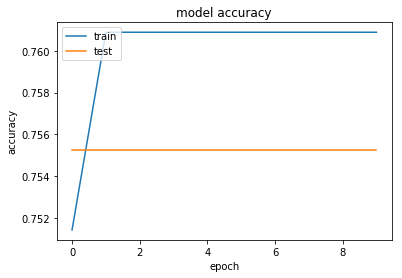

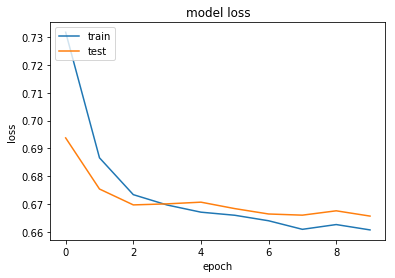

In [888]:
# Static
def create_model(X_train_cat, X_train_con):
    cat_input = Input(shape=(X_train_cat.shape[1],), name='Categorical_Input')
    con_input = Input(shape=(X_train_con.shape[1],), name='Continuous_Input')
    
    x = kerasconc([cat_input, con_input])
    x = Dense(20, activation='relu')(x)
    x = Dropout(0.2,)(x)
    x = Dense(20, activation='relu')(x)

    output = Dense(3, activation='softmax', name='output')(x)
    return cat_input, con_input, output

cat_input_static, con_input_static, output_static = create_model(X_train_cat_static, X_train_con_static)
model_static = Model(inputs=[cat_input_static, con_input_static], outputs=[output_static])
model_static.summary()
model_static.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

    
history = model_static.fit(
    [X_train_cat_static, X_train_con_static],
    Y_train_static,
    validation_split=0.33,
    shuffle=True,
    epochs=10,
    batch_size=batch_size)

def epoch_history_plot(history):
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

epoch_history_plot(history)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Categorical_Input (InputLayer)  (None, 9)            0                                            
__________________________________________________________________________________________________
Continuous_Input (InputLayer)   (None, 10)           0                                            
__________________________________________________________________________________________________
concatenate_30 (Concatenate)    (None, 19)           0           Categorical_Input[0][0]          
                                                                 Continuous_Input[0][0]           
__________________________________________________________________________________________________
dense_75 (Dense)                (None, 20)           400         concatenate_30[0][0]             
__________

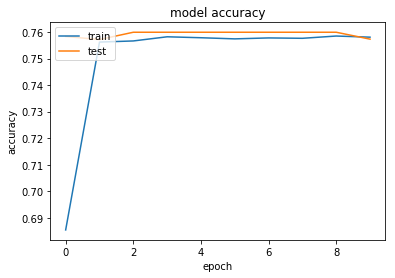

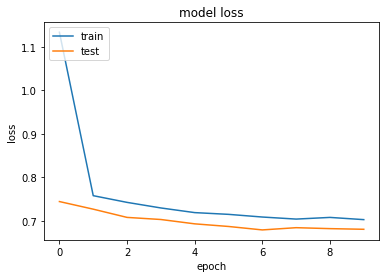

In [889]:
# Static + Depth
cat_input_depth, con_input_depth, output_depth = create_model(X_train_cat_depth, X_train_con_depth)
model_depth = Model(inputs=[cat_input_depth, con_input_depth], outputs=[output_depth])
model_depth.summary()
model_depth.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

history = model_depth.fit(
    [X_train_cat_depth, X_train_con_depth],
    Y_train_depth,
    validation_split=0.33,
    shuffle=True,
    epochs=10,
    batch_size=batch_size)

epoch_history_plot(history)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Categorical_Input (InputLayer)  (None, 9)            0                                            
__________________________________________________________________________________________________
Continuous_Input (InputLayer)   (None, 13)           0                                            
__________________________________________________________________________________________________
concatenate_33 (Concatenate)    (None, 22)           0           Categorical_Input[0][0]          
                                                                 Continuous_Input[0][0]           
__________________________________________________________________________________________________
dense_84 (Dense)                (None, 20)           460         concatenate_33[0][0]             
__________

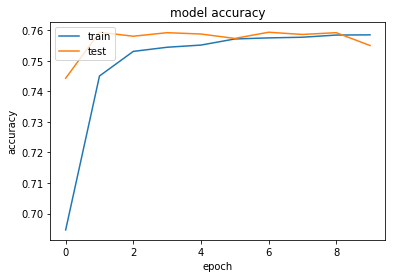

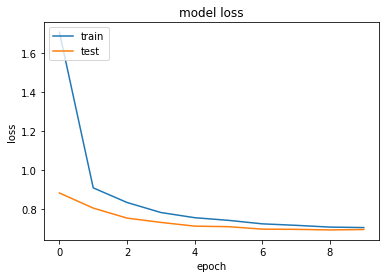

In [1029]:
# Static + Depth + User
cat_input_depth_user, con_input_depth_user, output_depth_user = create_model(X_train_cat_depth_user, X_train_con_depth_user)
model_depth_user = Model(inputs=[cat_input_depth_user, con_input_depth_user], outputs=[output_depth_user])
model_depth_user.summary()
model_depth_user.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

history = model_depth_user.fit(
    [X_train_cat_depth_user, X_train_con_depth_user],
    Y_train_depth_user,
    validation_split=0.33,
    shuffle=True,
    epochs=10,
    batch_size=batch_size)

epoch_history_plot(history)

In [854]:
# Predictions

# Static
ypred_con_depth_user = model_static.predict(
    [X_test_cat_static, X_test_con_static],
    batch_size=batch_size)

# Static + Depth
ypred_depth = model_depth.predict(
    [X_test_cat_depth, X_test_con_depth],
    batch_size=batch_size)

# Static + Depth + User
ypred_depth_user = model_depth_user.predict(
    [X_test_cat_depth_user, X_test_con_depth_user],
    batch_size=batch_size)

### Evaluation

##### Model Comparison regarding Accuracy, AUC and FPR

In [1030]:
# Accuracy

# Static
static_acc = model_static.evaluate(
    [X_test_cat_static, X_test_con_static],
    Y_test_static,
    batch_size=batch_size)[1]

# Static + Depth
depth_acc = model_depth.evaluate(
    [X_test_cat_depth, X_test_con_depth],
    Y_test_depth,
    batch_size=batch_size)[1]

# Static + Depth + User
depth_user_acc = model_depth_user.evaluate(
    [X_test_cat_depth_user, X_test_con_depth_user],
    Y_test_depth_user,
    batch_size=batch_size)[1]

20962/20962 [==============================] - 1s 56us/step


In [1031]:
# AUC
print(static_acc)
print(depth_acc)
print(depth_user_acc)

0.7590401701009998
0.7587539369784038
0.7590401705332059


In [ ]:
# FPR

##### ROC Curve for best model

In [ ]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(Y_train_depth_user[:, i], ypred_depth_user[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute macro-average ROC curve and ROC area
n_classes = 3
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

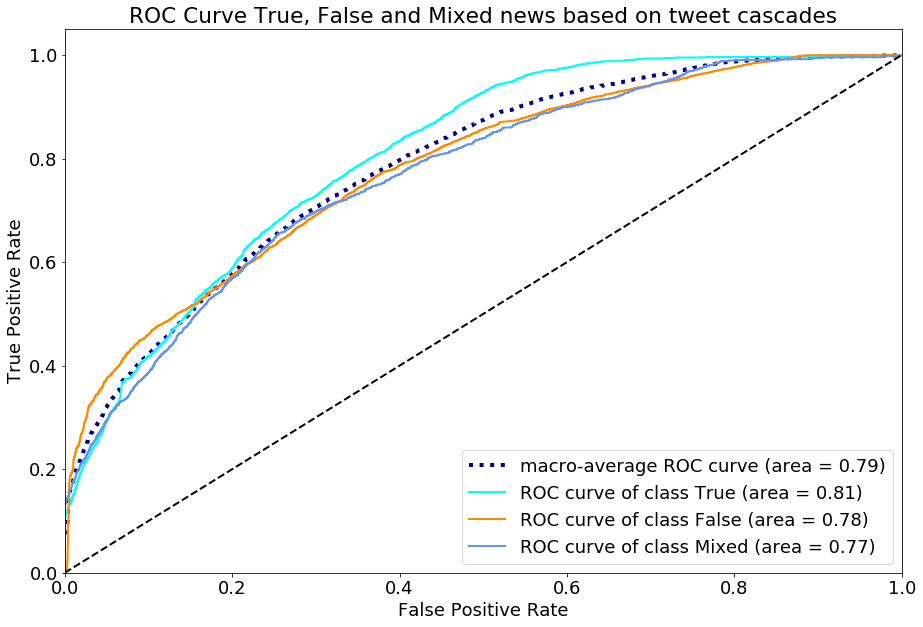

In [420]:
# Plot parameters
lw = 2
rcParams.update({'font.size': 18})

# Plot all ROC curves
plt.figure(figsize=(15,10))
plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

plt.plot(fpr[2], tpr[2], color = 'aqua', lw=lw,
            label='ROC curve of class True (area = {1:0.2f})'
             ''.format(2, roc_auc[2]))
plt.plot(fpr[0], tpr[0], color= 'darkorange', lw=lw,
            label='ROC curve of class False (area = {1:0.2f})'
             ''.format(0, roc_auc[0]))
plt.plot(fpr[1], tpr[1], color= 'cornflowerblue', lw=lw,
            label='ROC curve of class Mixed (area = {1:0.2f})' #check whether coding is correct
             ''.format(1, roc_auc[1]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve True, False and Mixed news based on tweet cascades')
plt.legend(loc="lower right")
plt.show()